In [39]:
import numpy as np
import matplotlib.pyplot as plt
import interneuron_amb
import stellate
from scipy import signal,optimize,stats
import phase_prec_hf as hf_p
import seaborn as sns
import sim_utils as s_utils
from neuron import h

h.load_file("stdrun.hoc")
h.celsius = 37
h.cvode.active(1)

import importlib
import analysis_utils as a_utils
importlib.reload(interneuron_amb)
importlib.reload(stellate)

<module 'stellate' from '/home/govind/gov_semproject/GridCellsTheta/GridCellsCond/stellate.py'>

In [40]:
print(h.dt)

0.009096193712690472


In [41]:
#Creating neurons and specifying weights
stellate_0 = stellate.Stellate(0)
interneuron_0 = interneuron_amb.Interneuron(0)

is_wt,si_wt = 1.0,1.0
is_inhb_gmax,si_exc_gmax = 1e-3,1e-3

nc_is = h.NetCon(interneuron_0.soma(0.5)._ref_v, stellate_0.inhb_syn, sec=interneuron_0.soma)
nc_is.weight[0] = is_inhb_gmax * is_wt

nc_si = h.NetCon(stellate_0.soma(0.5)._ref_v, interneuron_0.exc_syn, sec=stellate_0.soma)
nc_si.weight[0] = si_exc_gmax * si_wt

#theta current into interneuron

theta_ic = h.IClamp(interneuron_0.soma(0.5))
theta_ic.dur = 1e9
freq = 10
osc_amp = 2e-3
baseline_amp = 5e-4


#stellate drive
stell_ic = h.IClamp(stellate_0.soma(0.5))
stell_ic.dur = 1e9

In [42]:
def linear_ramp_response(base_stell_inh, stell_disn, slope):

    # durations (ms)
    pre_time = 5000     # 5 seconds baseline
    post_time = 5000    # 5 seconds baseline again

    # ramp duration determined by slope
    ramp_time = (stell_disn - base_stell_inh) / slope

    if ramp_time <= 0:
        raise ValueError("slope must be positive and stell_disn > base_stell_inh")

    t_pre = np.arange(0, pre_time, h.dt)
    t_ramp = np.arange(0, ramp_time, h.dt)
    t_post = np.arange(0, post_time, h.dt)

    # construct current waveform
    pre = np.full(len(t_pre), base_stell_inh)
    ramp = base_stell_inh + slope * t_ramp
    post = np.full(len(t_post), base_stell_inh)

    input_arr = np.concatenate((pre, ramp, post))

    time_arr = np.arange(0, len(input_arr) * h.dt, h.dt)

    # theta drive to interneuron
    intrnrn_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr / 1000) + baseline_amp
    intrnrn_vec = h.Vector(intrnrn_arr)
    intrnrn_vec.play(theta_ic._ref_amp, h.dt)

    # stellate ramp input
    stell_vec = h.Vector(input_arr)
    stell_vec.play(stell_ic._ref_amp, h.dt)

    # spike recorders
    spike_times_stell = h.Vector()
    spike_times_intrnrn = h.Vector()

    nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
    nc_stell.threshold = -20
    nc_stell.record(spike_times_stell)

    nc_intrnrn = h.NetCon(interneuron_0.soma(0.5)._ref_v, None, sec=interneuron_0.soma)
    nc_intrnrn.threshold = -20
    nc_intrnrn.record(spike_times_intrnrn)

    time = h.Vector().record(h._ref_t)

    h.finitialize(-65)
    h.t = 0
    h.continuerun(len(input_arr) * h.dt)

    return spike_times_stell, spike_times_intrnrn, time


In [50]:
h.dt = 0.1

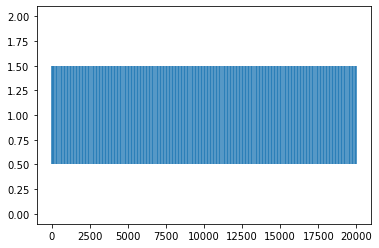

In [51]:
def exponential_ramp_response(base_stell_inh, stell_disn, tau):

    pre_time = 5000     # 5 seconds baseline
    post_time = 5000    # 5 seconds baseline again
    ramp_time = 10000

    t_pre = np.arange(0, pre_time, h.dt)
    t_ramp = np.arange(0, ramp_time, h.dt)
    t_post = np.arange(0, post_time, h.dt)

    pre = np.full(len(t_pre), base_stell_inh)
    ramp = base_stell_inh + (stell_disn - base_stell_inh) * (1 - np.exp(-t_ramp / tau))
    post = np.full(len(t_post), base_stell_inh)

    input_arr = np.concatenate((pre, ramp, post))
    time_arr = np.arange(0, len(input_arr) * h.dt, h.dt)

    intrnrn_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr / 1000) + baseline_amp
    intrnrn_vec = h.Vector(intrnrn_arr)
    intrnrn_vec.play(theta_ic._ref_amp, h.dt)

    # stellate ramp input
    stell_vec = h.Vector(input_arr)
    stell_vec.play(stell_ic._ref_amp, h.dt)

    # spike recorders
    spike_times_stell = h.Vector()
    spike_times_intrnrn = h.Vector()

    nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
    nc_stell.threshold = -20
    nc_stell.record(spike_times_stell)

    nc_intrnrn = h.NetCon(interneuron_0.soma(0.5)._ref_v, None, sec=interneuron_0.soma)
    nc_intrnrn.threshold = -20
    nc_intrnrn.record(spike_times_intrnrn)

    time = h.Vector().record(h._ref_t)
    h.finitialize(-65)
    h.t = 0
    tstop = pre_time + ramp_time + post_time
    h.continuerun(tstop)
    return spike_times_stell, spike_times_intrnrn, time


stell_spks, intrnrn_spks, time   = exponential_ramp_response(-1e-3, 5e-9, 2000)

plt.eventplot(stell_spks.to_python(), label="Stellate spikes")


    

    



In [ ]:
def ramp_response(time_ms=20000,
                  baseline_stell=-5e-3,
                  ds_inh=5e-5,
                  str_input=2000,
                  end_input=8000,
                  ramp_type="gaussian",
                  sigma=1200,
                  slope=None,
                  tau=None):

    dt = h.dt
    time_arr = np.arange(0, time_ms, dt)

    # ---- stellate waveform ----
    stell_arr = np.full_like(time_arr, baseline_stell)

    if ramp_type == "gaussian":
        peak_t = (end_input + str_input) / 2
        ramp = (ds_inh - baseline_stell) * np.exp(
            -(time_arr[str_input:end_input] - peak_t)**2 / (2 * sigma**2)
        )
        stell_arr[str_input:end_input] = ramp + baseline_stell

    elif ramp_type == "linear":
        ramp = baseline_stell + (ds_inh - baseline_stell) * (
            (time_arr[str_input:end_input] - str_input) /
            (end_input - str_input)
        )
        stell_arr[str_input:end_input] = ramp

    elif ramp_type == "exponential":
        ramp = baseline_stell + (ds_inh - baseline_stell) * (
            1 - np.exp(-(time_arr[str_input:end_input] - str_input) / tau)
        )
        stell_arr[str_input:end_input] = ramp

    else:
        raise ValueError("ramp_type must be gaussian, linear, or exponential")

    stell_vec = h.Vector(stell_arr)
    stell_vec.play(stell_ic._ref_amp, h.dt)

    # ---- theta waveform ----
    curr_arr = osc_amp * np.sin(2 * np.pi * freq * time_arr / 1000) + baseline_amp
    curr_vec = h.Vector(curr_arr)
    curr_vec.play(theta_ic._ref_amp, h.dt)

    # ---- spike recorders ----
    spike_times_stell = h.Vector()
    spike_times_intrnrn = h.Vector()

    nc_stell = h.NetCon(stellate_0.soma(0.5)._ref_v, None, sec=stellate_0.soma)
    nc_stell.threshold = -20
    nc_stell.record(spike_times_stell)

    nc_intrnrn = h.NetCon(interneuron_0.soma(0.5)._ref_v, None, sec=interneuron_0.soma)
    nc_intrnrn.threshold = -20
    nc_intrnrn.record(spike_times_intrnrn)

    time = h.Vector().record(h._ref_t)

    h.finitialize(-65)
    h.t = 0
    h.continuerun(time_ms)

    return spike_times_stell, spike_times_intrnrn, time

test0 = ramp_response(ramp_type="gaussian", sigma=1200)



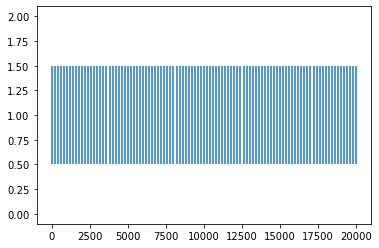

In [54]:
plt.eventplot(test0[0].to_python(), label="Stellate spikes")